In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
np.set_printoptions(precision=1,suppress=True)
%matplotlib inline
import matplotlib
%config InlineBackend.figure_format = 'jpg'
matplotlib.figure.Figure.__repr__ = lambda self: (
    f"<{self.__class__.__name__} size {self.bbox.size[0]:g}"
    f"x{self.bbox.size[1]:g} with {len(self.axes)} Axes>")
import matplotlib.pyplot as plt
plt.style.use('PR.mplstyle')

In [2]:
from scipy.stats import t as student

In [3]:
dfBeers = pd.read_csv('data/beers.csv')
dfBrewers = pd.read_csv('data/breweries.csv')

dfBeers = dfBeers.rename(columns={'Unnamed: 0' : 'rowNum'})
dfBrewers = dfBrewers.rename(columns={'Unnamed: 0' : 'brewery_id'})

#striping whitespaces
dfBeers['name'] = dfBeers['name'].str.strip()
dfBeers['style'] = dfBeers['style'].str.strip()
dfBrewers['name'] = dfBrewers['name'].str.strip()
dfBrewers['city'] = dfBrewers['city'].str.strip()
dfBrewers['state'] = dfBrewers['state'].str.strip()

dfBeers.info()
dfBrewers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rowNum      2410 non-null   int64  
 1   abv         2348 non-null   float64
 2   ibu         1405 non-null   float64
 3   id          2410 non-null   int64  
 4   name        2410 non-null   object 
 5   style       2405 non-null   object 
 6   brewery_id  2410 non-null   int64  
 7   ounces      2410 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 150.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   brewery_id  558 non-null    int64 
 1   name        558 non-null    object
 2   city        558 non-null    object
 3   state       558 non-null    object
dtypes: int64(1), object(3)
memory usage: 17.6+ KB


In [4]:
#fixing missing alcohol levels

#seperate beers that have abv and ones that don't
notValid = dfBeers[dfBeers['abv'].isna()]
valid = dfBeers[dfBeers['abv'].notna()]

for ind in notValid.index:
    filter = dfBeers['rowNum'] == notValid['rowNum'][ind] 
    sameStyle = valid['style'] == notValid['style'][ind] #filter to find beers from same style
    newValue = (valid[sameStyle]['abv']).median() # make missing values equal to median of same style beers(hot deck method)
    
    #incase there are no other valid beers from same style, make value equal to median of whole dataset
    if math.isnan(newValue):
        newValue = valid['abv'].median()
    
    dfBeers.loc[filter,'abv'] = newValue

In [5]:
dfBeers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rowNum      2410 non-null   int64  
 1   abv         2410 non-null   float64
 2   ibu         1405 non-null   float64
 3   id          2410 non-null   int64  
 4   name        2410 non-null   object 
 5   style       2405 non-null   object 
 6   brewery_id  2410 non-null   int64  
 7   ounces      2410 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 150.8+ KB


In [6]:
#fixing missing styles
#we make missing styles equal to most common style(mode) from whole dataset

#seperate beers that have style and ones that don't
notValid = dfBeers[dfBeers['style'].isna()]
valid = dfBeers[dfBeers['style'].notna()]

for ind in notValid.index:
    filter = dfBeers['rowNum'] == notValid['rowNum'][ind] 
    dfBeers.loc[filter,'style'] = dfBeers['style'].mode()[0]

In [7]:
dfBeers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rowNum      2410 non-null   int64  
 1   abv         2410 non-null   float64
 2   ibu         1405 non-null   float64
 3   id          2410 non-null   int64  
 4   name        2410 non-null   object 
 5   style       2410 non-null   object 
 6   brewery_id  2410 non-null   int64  
 7   ounces      2410 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 150.8+ KB


In [75]:
#fixing missing ibu values
#We use multiple imputation with MICE

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#Create numpy array from dataframe and remove categorical data
arrBeers = dfBeers.to_numpy()
arrBeers = np.delete(arrBeers, 4, 1)
arrBeers = np.delete(arrBeers, 4, 1)

print(arrBeers)

imp = IterativeImputer(max_iter=30, random_state=42, verbose=1, imputation_order="roman", initial_strategy="mean", sample_posterior=True, missing_values=np.nan)

arrBeers = imp.fit_transform(arrBeers)

[[0 0.05 nan 1436 408 12.0]
 [1 0.066 nan 2265 177 12.0]
 [2 0.071 nan 2264 177 12.0]
 ...
 [2407 0.055 nan 620 424 12.0]
 [2408 0.055 40.0 145 424 12.0]
 [2409 0.052 nan 84 424 12.0]]
[IterativeImputer] Completing matrix with shape (2410, 6)


In [76]:
arrBeers

array([[   0. ,    0.1,   95.4, 1436. ,  408. ,   12. ],
       [   1. ,    0.1,   15.6, 2265. ,  177. ,   12. ],
       [   2. ,    0.1,   79.9, 2264. ,  177. ,   12. ],
       ...,
       [2407. ,    0.1,   44.8,  620. ,  424. ,   12. ],
       [2408. ,    0.1,   40. ,  145. ,  424. ,   12. ],
       [2409. ,    0.1,   13. ,   84. ,  424. ,   12. ]])

In [47]:
dfBeers.head()

,rowNum,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


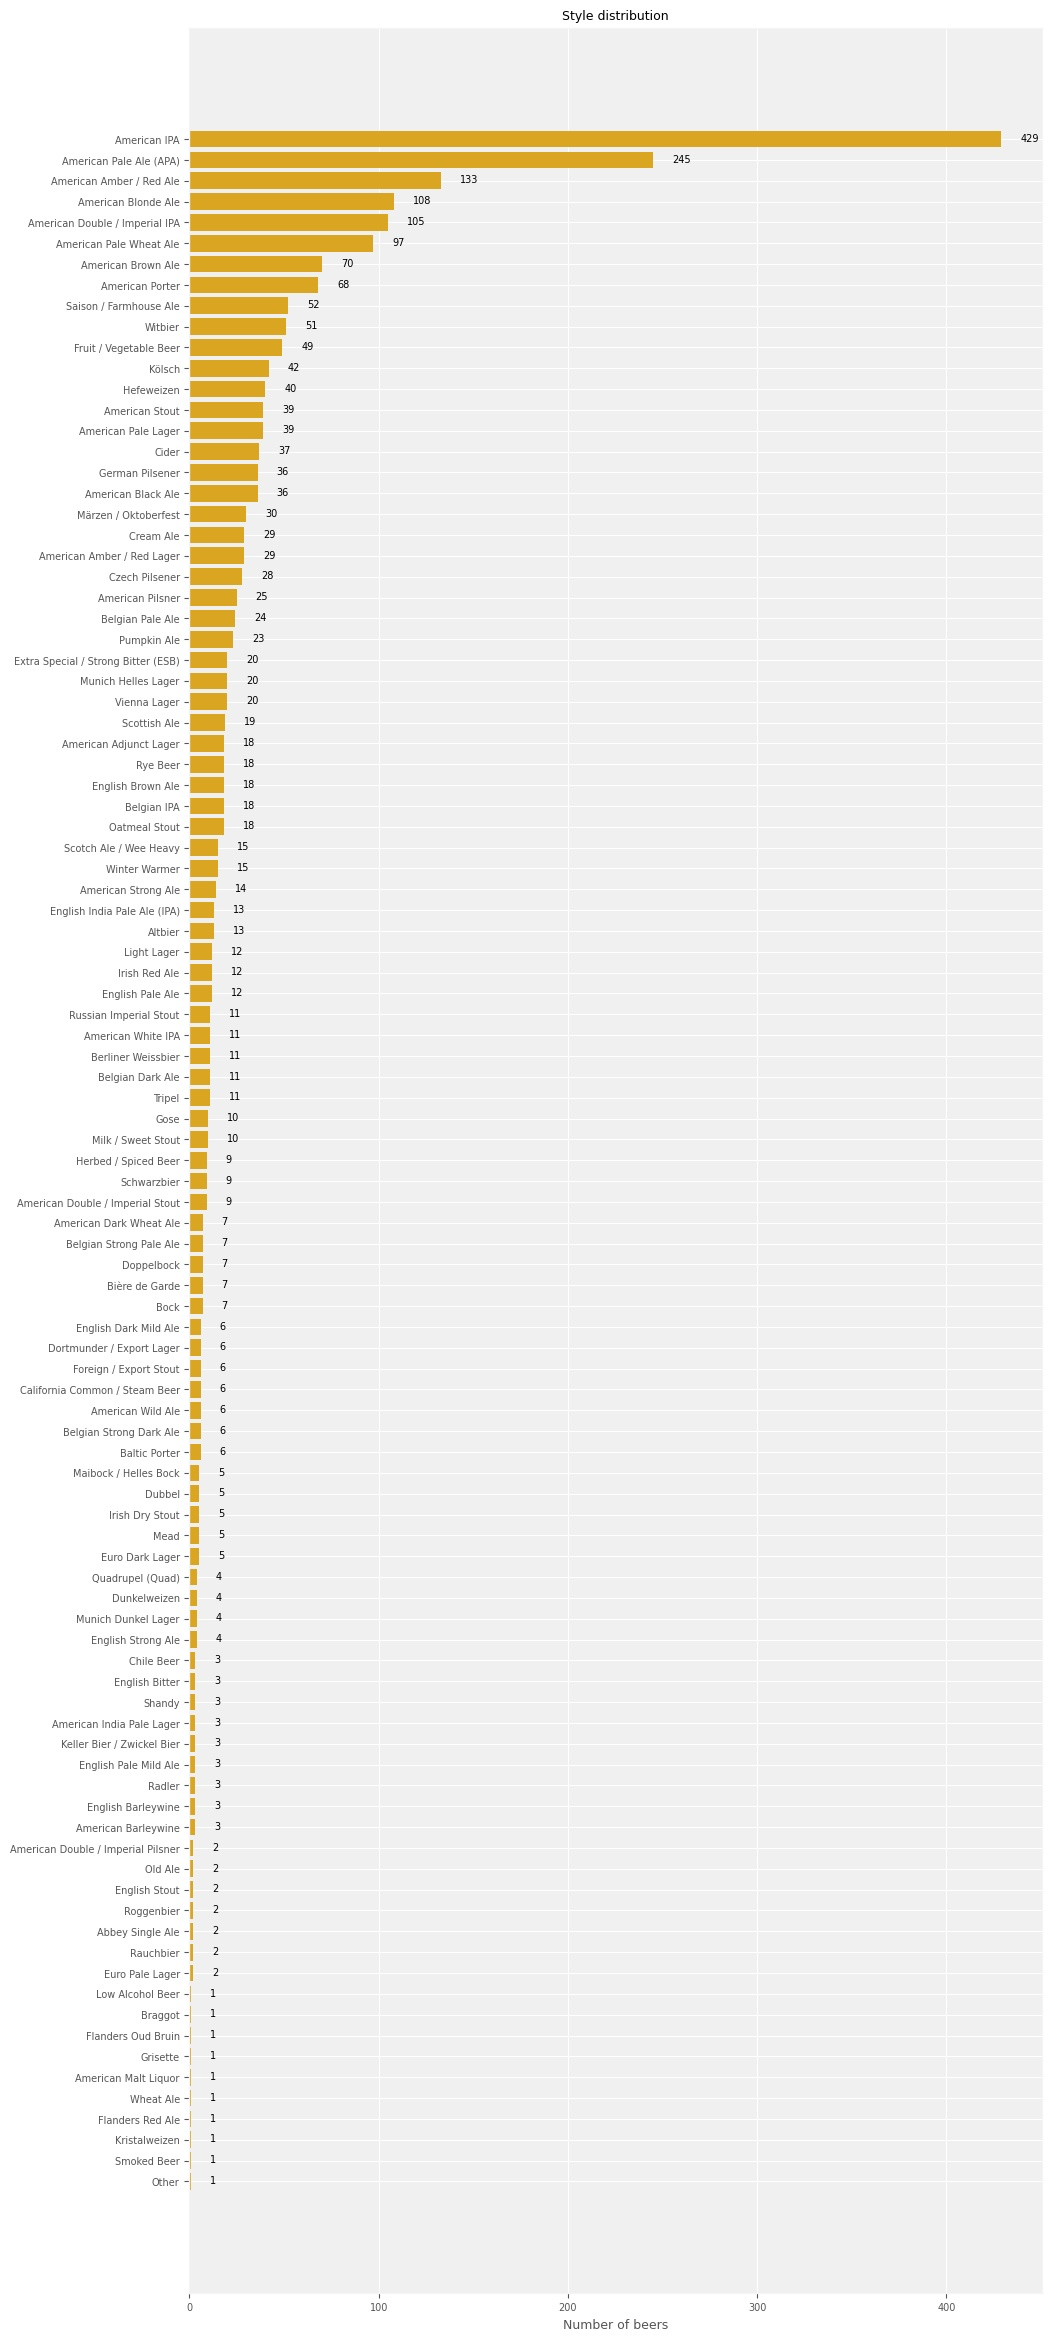

In [10]:
#checking style distributions

styleDict = {}

for ind in dfBeers.index:
    temp = dfBeers['style'][ind]
    if temp not in styleDict:
        styleDict[temp] = 1
    else:
        styleDict[temp] += 1

styles_sorted  = sorted(styleDict.keys(), key=lambda x: styleDict[x])
x = [styleDict[style] for style in styles_sorted]
y = range(len(styles_sorted))
plt.figure(figsize=(11, 30));
plt.barh(y, x, color='goldenrod')
plt.yticks(y);
plt.gca().set_yticklabels(styles_sorted)
#plt.ylim(-0.5, len(styles_sorted)-0.5)
plt.xlabel("Number of beers");
for i in y:
    plt.text(10 + x[i], i-0.1, 
             f"{x[i]}");
plt.title("Style distribution");


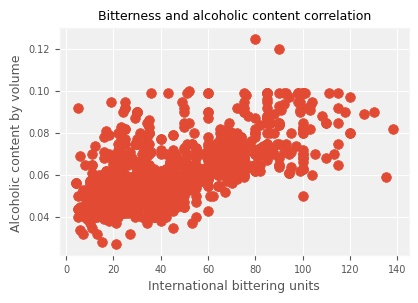

In [11]:
plt.scatter(dfBeers.ibu, dfBeers.abv)
plt.xlabel("International bittering units")
plt.ylabel("Alcoholic content by volume ")
plt.title("Bitterness and alcoholic content correlation");

In [12]:
def pearson(x, y):
    return np.mean(((x - np.mean(x))*(y-np.mean(y)))/(np.std(x)*np.std(y)))

In [13]:
pearson(dfBeers.ibu, dfBeers.abv)

0.6769756239271906

Pearson shows a good positive correlation

In [14]:
top_ten_styles = set(styles_sorted[-10:])

top_beers_df = dfBeers[dfBeers['style'].isin(top_ten_styles)]
bit = []
for bitterness in top_beers_df['ibu']:
    if np.isnan(bitterness):
        bit.append(np.nan)
    elif bitterness <= 50:
        bit.append('Low')
    elif bitterness <= 94:
        bit.append('Medium')
    else:
        bit.append('High')

top_beers_df.insert(len(top_beers_df.columns), "Bitterness", bit, True)
#df.loc[df.Weight == "155", "Name"] = "John"
top_beers_df

,rowNum,abv,ibu,id,name,style,brewery_id,ounces,Bitterness
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0,NaN
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0,NaN
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0,NaN
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0,NaN
6,6,0.045,NaN,2260,Lake Street Express,American Pale Ale (APA),177,12.0,NaN
...,...,...,...,...,...,...,...,...,...
2399,2399,0.069,69.0,1512,Worthy IPA (2013),American IPA,199,12.0,Medium
2400,2400,0.060,50.0,1511,Worthy Pale,American Pale Ale (APA),199,12.0,Low
2406,2406,0.052,NaN,807,Rail Yard Ale,American Amber / Red Ale,424,12.0,NaN
2408,2408,0.055,40.0,145,Silverback Pale Ale,American Pale Ale (APA),424,12.0,Low


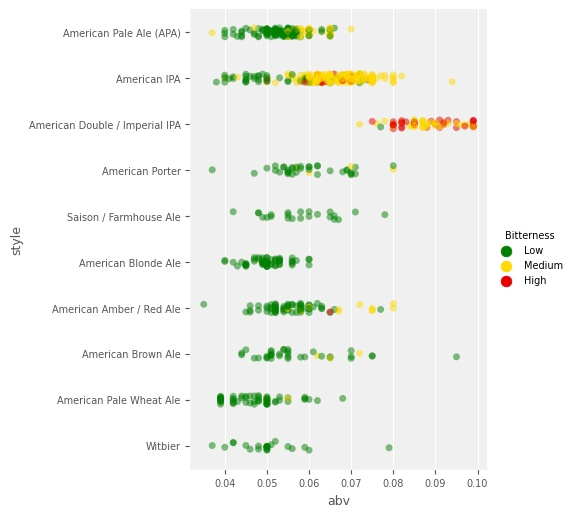

In [15]:
ax = sns.catplot(y="style", x="abv", jitter=True, data=top_beers_df, hue="Bitterness", 
                 palette=[(0, 0.5, 0), (1, 0.85, 0), (0.9, 0, 0)], legend=True, 
                 hue_order= ["Low", "Medium", "High"], alpha=0.5);

In [16]:
#Grouping states into regions

northEastArr = set(["ME","MA","RI", "CT", "NH", "VT", "NY", "PA", "NJ", "DE", "MD"])
southEastArr = set(["WV","VA", "KY", "TN", "NC", "SC", "GA", "AL", "MS", "AR", "LA", "FL"])
midWestArr = set(["OH", "IN", "MI", "IL", "MS", "WI", "MN", "IA", "KS", "NE", "SD", "ND"])
southWestArr = set(["TX", "OK", "NM", "AZ"])
westArr = set(["CO", "WY", "MT", "ID", "WA", "OR", "UT", "NV", "CA", "AK", "HI"])

northEastBrewers = dfBrewers[dfBrewers['state'].isin(northEastArr)]['brewery_id']
southEastBrewers = dfBrewers[dfBrewers['state'].isin(southEastArr)]['brewery_id']
midWestBrewers = dfBrewers[dfBrewers['state'].isin(midWestArr)]['brewery_id']
southWestBrewers = dfBrewers[dfBrewers['state'].isin(southWestArr)]['brewery_id']
westBrewers = dfBrewers[dfBrewers['state'].isin(westArr)]['brewery_id']

NE_Beers = dfBeers[dfBeers['brewery_id'].isin(northEastBrewers)]
SE_Beers = dfBeers[dfBeers['brewery_id'].isin(southEastBrewers)]
MW_Beers = dfBeers[dfBeers['brewery_id'].isin(midWestBrewers)]
SW_Beers = dfBeers[dfBeers['brewery_id'].isin(southWestBrewers)]
W_Beers = dfBeers[dfBeers['brewery_id'].isin(westBrewers)]

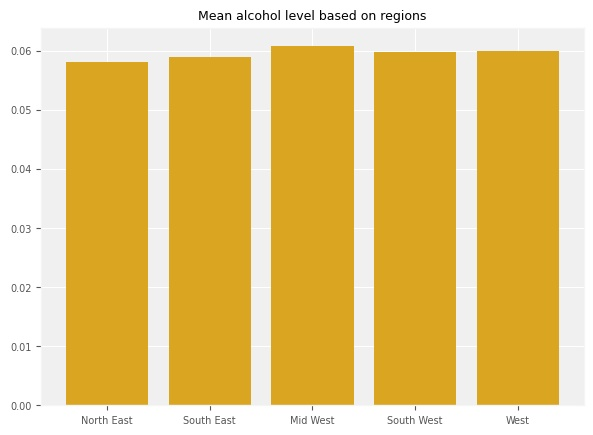

In [17]:
#checking mean alcohol level based on region
xAxis = ['North East', 'South East', 'Mid West', 'South West', 'West']
yAxis = [NE_Beers['abv'].mean(), SE_Beers['abv'].mean(), MW_Beers['abv'].mean(), SW_Beers['abv'].mean(), W_Beers['abv'].mean()]

plt.figure(figsize=(7, 5));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Mean alcohol level based on regions");

There does not seem to be much of a difference in alcohol levels between regions.

Now we'll illustrate the most popular beer styles in each region

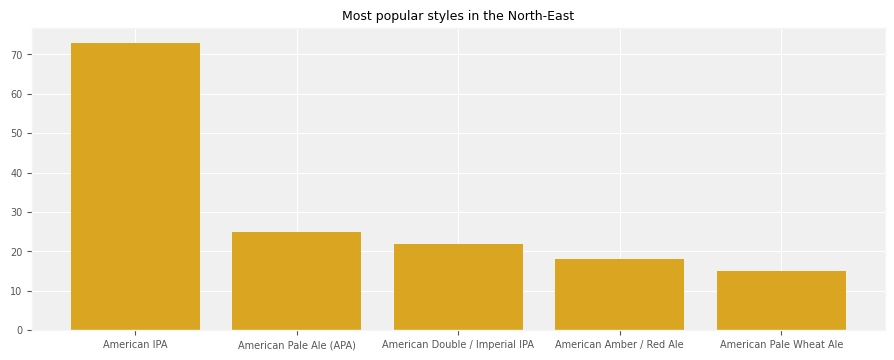

In [18]:
#North-East
s = NE_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Most popular styles in the North-East");

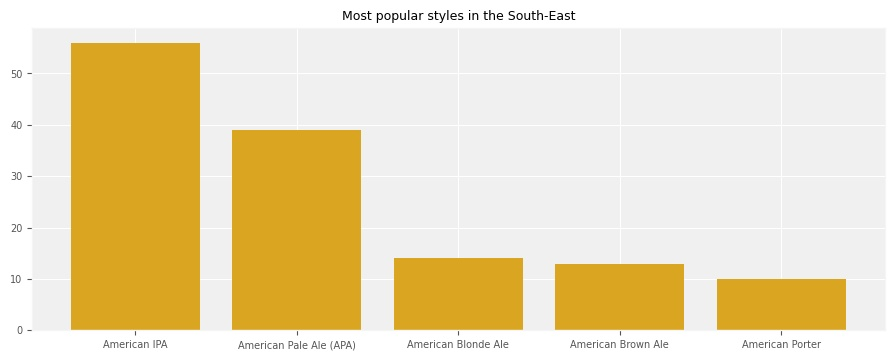

In [19]:
#South-East
s = SE_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Most popular styles in the South-East");

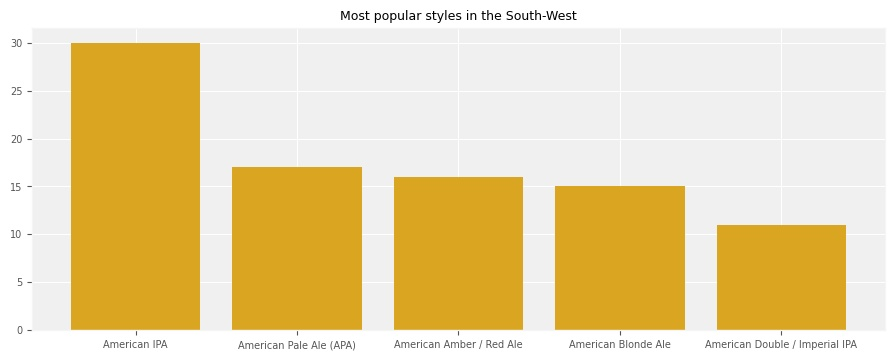

In [20]:
#South-West
s = SW_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Most popular styles in the South-West");

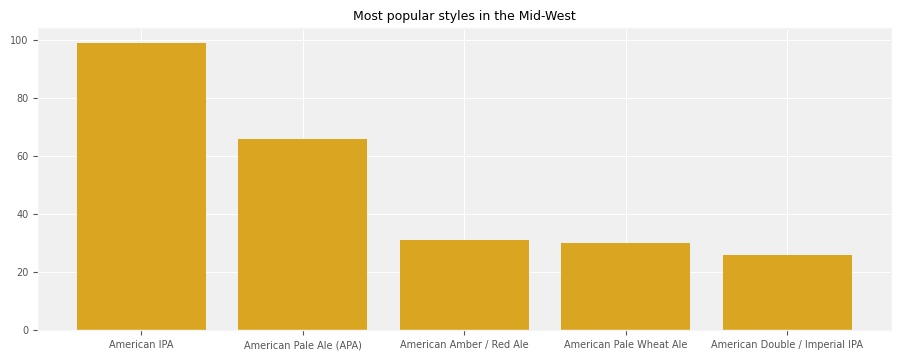

In [21]:
#Mid-West
s = MW_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod')
plt.title("Most popular styles in the Mid-West");

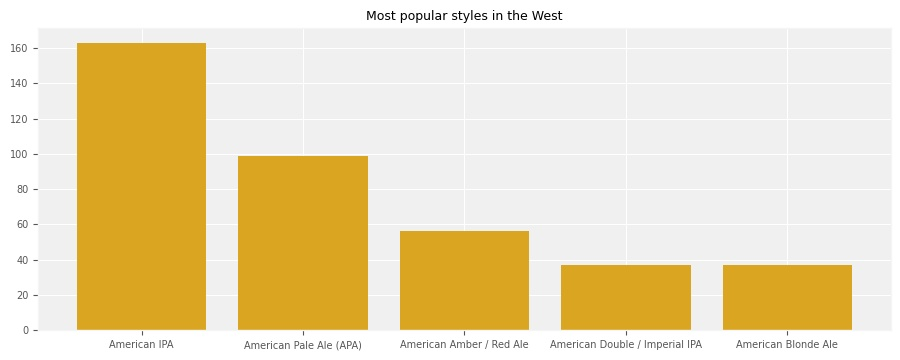

In [22]:
#West
s = W_Beers['style'].value_counts()[:5]
yAxis = s.tolist()
xAxis = s.index.tolist()

plt.figure(figsize=(11, 4));
plt.bar(xAxis, yAxis, color='goldenrod');
plt.title("Most popular styles in the West");

In [23]:
#Distributions for bitterness and alcohol levels of each beer

bitterness = []
alcoholLevels = []
for name in set(dfBeers["name"]):
    ibu = [x for x in dfBeers["ibu"][dfBeers["name"]==name] if np.isnan(x)==False]
    abv = [x for x in dfBeers["abv"][dfBeers["name"]==name] if np.isnan(x)==False]
    if (len(ibu)>0):
        bitterness.append(np.mean(ibu))
    if (len(abv)>0):
        alcoholLevels.append(np.mean(abv))

In [24]:
from scipy.stats import beta
import warnings
warnings.filterwarnings('ignore')

def betaDistribution(a, b, samples, labels):
    for i in range(len(samples)):
        sample = samples[i]
        xr = np.linspace(0, np.max(sample), 100)     
        parameters_Beta = beta.fit(sample)
        P_fit_Beta = [beta.pdf(x, *parameters_Beta) for x in xr]
        if (i%2==0):
            plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, int(i%2)+1)
        plt.hist(sample,    label="Sample", density=True)
        plt.plot(xr, P_fit_Beta, label="Model", linewidth=2.0)
        plt.title("Beta distribution for "+labels[i])
        plt.legend()
        if ((i-1)%2==0 and i>0):
            plt.show()
    plt.show()

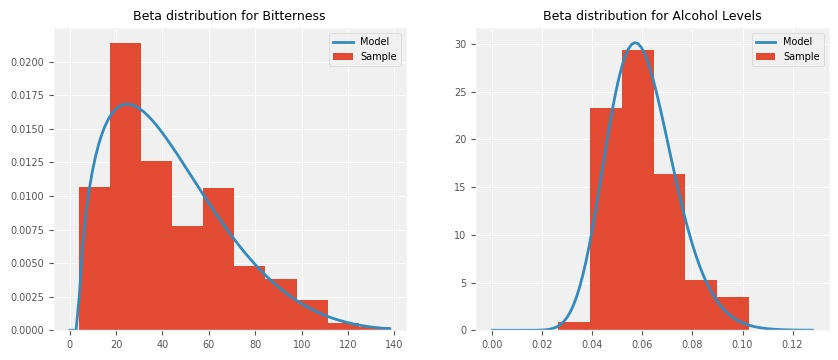

In [25]:
betaDistribution(0, 1, [bitterness, alcoholLevels], ["Bitterness", "Alcohol Levels"])

Because there are way to many types of beers, we split them by regions for clustering.

In [26]:
import Orange
import scipy.cluster.hierarchy as sch
import scipy
from sklearn.metrics import silhouette_score
from collections import defaultdict

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [27]:
def init_clusters(dataset):
    names = sorted(list(set(dataset["name"])))
    styles = sorted(list(set(dataset["style"])))
    breweryID = sorted(list(set(dataset["brewery_id"])))
    matrix = []
    for name in names:
        row = []
        ibu = np.mean(dataset["ibu"][dataset["name"]==name])
        abv = np.mean(dataset["abv"][dataset["name"]==name])
        #if (np.isnan(ibu)):  #uncomment these lines for -1 instead of NaN for ibu and abv
            #row.append(-1)
        #else:
        row.append(ibu)
        #if (np.isnan(abv)):
            #row.append(-1)
        #else:
        row.append(abv)
        style = [x for x in set(dataset["style"][dataset["name"]==name])][0]
        for s in styles:
            if style==s:
                row.append(1)
            else:
                row.append(0)
        bid = [x for x in set(dataset["brewery_id"][dataset["name"]==name])][0]
        for b in breweryID:
            if bid==b:
                row.append(1)
            else:
                row.append(0)
        matrix.append(row)
    return matrix, names

def draw_clusters(matrix, dataset, method, metric, t):
    L = sch.linkage(np.array(matrix), method=method, metric=metric)
    predictions = sch.fcluster(L, t=t, criterion="distance").ravel()
    classes     = np.array(matrix).ravel()
    
    plt.figure(figsize=(25, 6))
    names = sorted(list(set(dataset["name"])))
    labels = [name for name in names]
    D      = sch.dendrogram(L, labels=labels, leaf_font_size=15);
    plt.plot([0, len(dataset)*10], [t, t], "k--")
    plt.ylabel("Razdalja")
    plt.show()
    return predictions

def score_clusters(matrix, predictions, metric): 
    score = silhouette_score(matrix, predictions, metric=metric)
    #score = calinski_harabasz_score(matrix,predictions)
    #score = davies_bouldin_score(matrix,predictions)
    return score

In [28]:
def getState(state):
    bid = dfBrewers["brewery_id"][dfBrewers["state"]==state]
    return dfBeers[dfBeers["brewery_id"].isin(bid)]

In [29]:
#get clusters as dictionary
def get_separate_clusters(linkage, names):
    groups_by_names = defaultdict(list)
    for group, name in zip(linkage, names):
        groups_by_names[group].append(name)
    return groups_by_names

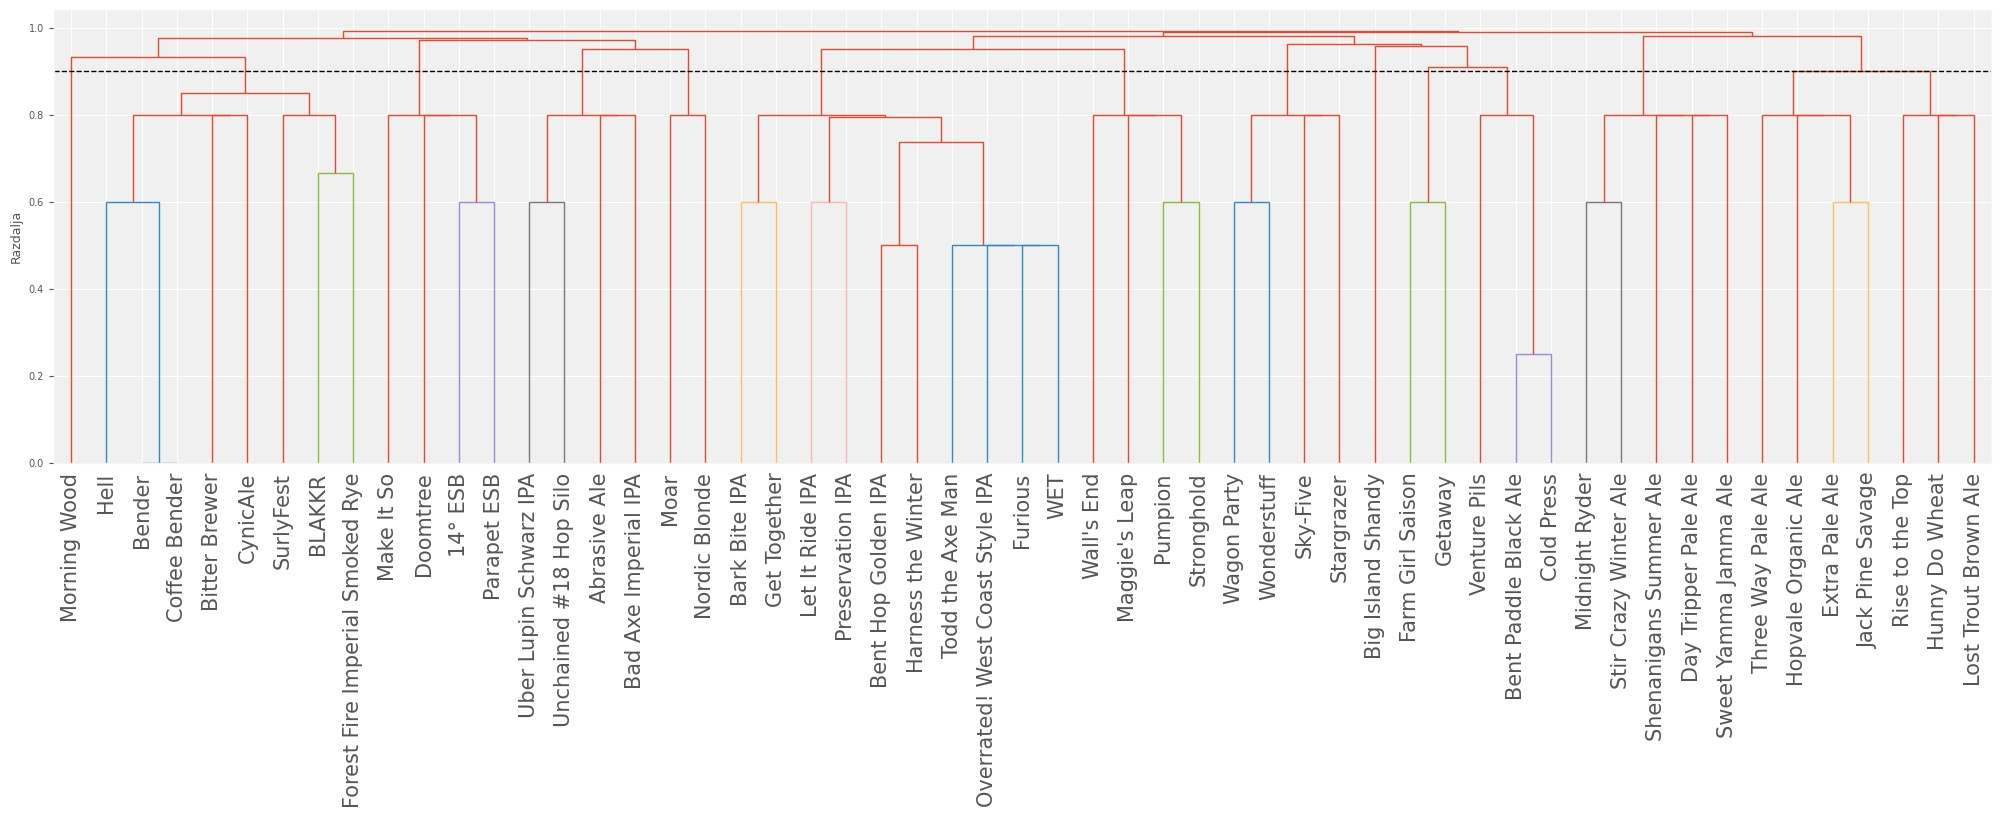

In [30]:
#State clusters
state = getState("MN")
clusters, names = init_clusters(state)
linkage = draw_clusters(clusters, state, "weighted", "jaccard", 0.9)

In [31]:
score_clusters(clusters, linkage, "jaccard")

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
groups_by_names = get_separate_clusters(linkage, names)
groups_by_names

In [ ]:
# South-West region clusters
clusters, names = init_clusters(SW_Beers)
linkage = draw_clusters(clusters, SW_Beers, "weighted", "jaccard", 0.9)

In [ ]:
clusters, names = init_clusters(SW_Beers)
linkage = draw_clusters(clusters, SW_Beers, "complete", "jaccard", 0.9)

In [ ]:
score_clusters(clusters, linkage, "jaccard")